In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from shapely.geometry import LineString, Point

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  c:\Users\Davide\Git\pypsa-africa
Had to go 1 folder(s) up.


In [2]:
# load shapes
continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

<AxesSubplot:>

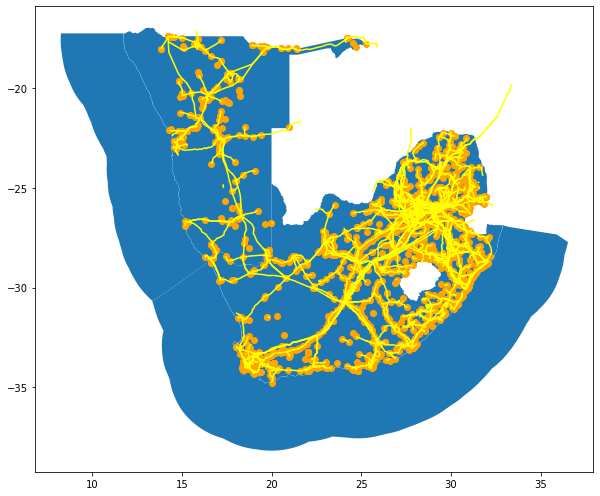

In [3]:
# plot output download_osm_data
df_substations_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_substations.geojson")
df_lines_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_download.plot(ax=ax, color="orange")
df_lines_osm_download.plot(ax=ax, color="yellow")

<AxesSubplot:>

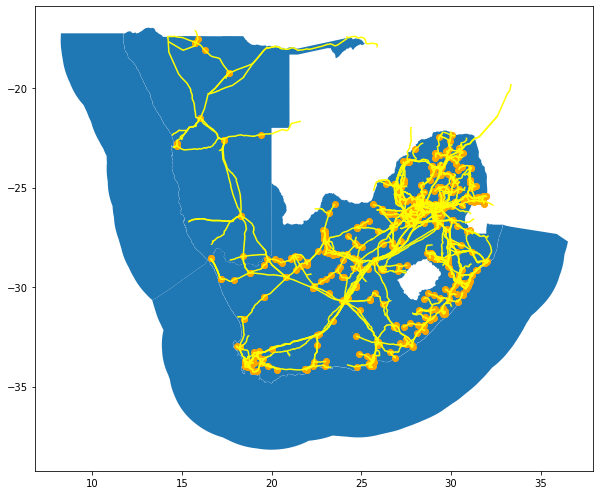

In [5]:
# plot output osm_data_cleaning
df_substations_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_substations.geojson")
df_lines_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_clean.plot(ax=ax, color="orange")
df_lines_osm_clean.plot(ax=ax, color="yellow")

In [6]:
os.getcwd()+"/data/osm/africa_all_lines_build_network.csv"

'c:\\Users\\Davide\\Git\\pypsa-africa/data/osm/africa_all_lines_build_network.csv'

In [7]:
# plot output build_osm_network
df_substations_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_buses_build_network.csv")
df_lines_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_lines_build_network.csv")


df_substations_osm_build_network = gpd.GeoDataFrame(geometry=df_substations_osm_build_network_pd.geometry, crs='epsg:4326')
#df_lines_osm_build_network = gpd.GeoDataFrame(geometry=df_lines_osm_build_network_pd.geometry, crs='epsg:4326')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="orange")
#df_lines_osm_build_network.plot(ax=ax, color="yellow")

TypeError: Input must be valid geometry objects: LINESTRING (30.00507760000012 -24.40640149999983, 30.00374420000012 -24.40547579999983, 30.00173790000012 -24.40407129999983, 29.99984970000012 -24.40274499999983, 29.9979435 -24.40139020000002, 29.9959376000001 -24.39999339999983, 29.99463810000011 -24.39909199999983, 29.9942652 -24.39838630000002, 29.9937557000001 -24.39736259999983, 29.9924656000001 -24.39480749999982, 29.9914417 -24.39279590000002, 29.9903226 -24.390567, 29.9890604000001 -24.38805319999982, 29.987825 -24.38561880000002, 29.9867917 -24.38357960000003, 29.9855501 -24.38107320000002, 29.9843314 -24.37892140000002, 29.9832782 -24.376841, 29.9822313 -24.374773, 29.9811852 -24.37267920000003, 29.9800989 -24.37054140000003, 29.97885840000001 -24.36811650000003, 29.977657 -24.36561360000003, 29.976338 -24.36301680000003, 29.975059 -24.360624, 29.97435230000001 -24.35921660000003, 29.97351410000001 -24.35754780000003, 29.97305270000001 -24.35665720000003, 29.97249360000001 -24.35649050000003, 29.97120470000002 -24.35610610000003, 29.96900190000002 -24.35544930000003, 29.96665770000002 -24.35476010000003, 29.96426990000002 -24.35405660000002, 29.96183360000002 -24.35334530000003, 29.95933750000002 -24.35260330000003, 29.95688490000002 -24.35188470000003, 29.95460150000001 -24.35117550000002, 29.95221670000001 -24.350463, 29.94991580000001 -24.34980450000003, 29.9475137000001 -24.34908939999982, 29.94496910000001 -24.34787890000003, 29.94217120000001 -24.34654780000003, 29.94048590000002 -24.34576140000003, 29.93881240000002 -24.34494850000003, 29.93712 -24.344143, 29.93474 -24.34296930000003, 29.93253860000002 -24.34195520000003, 29.93027360000002 -24.34087610000003, 29.92799960000002 -24.33979270000003, 29.92569250000002 -24.33869360000003, 29.92345640000002 -24.33762820000003, 29.92129450000002 -24.336594, 29.918903 -24.33543750000003, 29.91663560000002 -24.33435550000003, 29.91408090000002 -24.33315250000003, 29.91148550000002 -24.33191520000003, 29.9088899000001 -24.33067779999982, 29.90606230000002 -24.32932660000003, 29.9034021000001 -24.32805539999982, 29.90103370000011 -24.32692619999982, 29.89875010000002 -24.32583880000003, 29.89657320000011 -24.32480229999982, 29.89431750000011 -24.32372689999982, 29.8919974000001 -24.32262219999982, 29.8898194000001 -24.32157609999982, 29.8871077000001 -24.32028309999982, 29.8844469000001 -24.31900969999982, 29.8821832000001 -24.31793669999982, 29.8797450000001 -24.31677319999982, 29.8767731000001 -24.31536289999982, 29.87424840000002 -24.31413650000003, 29.87211960000002 -24.31312030000003, 29.86988810000002 -24.31204740000003, 29.8673076000001 -24.31083599999982, 29.8643599000001 -24.30941819999982, 29.8616696000001 -24.30814229999982, 29.8592851000001 -24.30700319999982, 29.8566271000001 -24.30574179999982, 29.8538832000001 -24.30444619999982, 29.8529498000001 -24.30398909999982, 29.8516462000001 -24.30313599999982, 29.85133610000002 -24.30295690000003, 29.85106550000011 -24.30285529999982)